In [64]:
from training import *
from analysis import *
from network import *

## accurarcy results on MNIST dataset

/var/folders/rg/pzd9xj053l3crlmhghvldndr0000gn/T/ipykernel_14002/3994538728.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1')


15
$D_{hidden} =20$, 1 parallel synapse acc mean +/- std: 95.36 \pm 0.08 \%
15
$D_{hidden} =20$, 2 parallel synapses acc mean +/- std: 95.83 \pm 0.06 \%
15
$D_{hidden} =20$, 3 parallel synapses acc mean +/- std: 96.01 \pm 0.06 \%
15
$D_{hidden} =20$, 5 parallel synapses acc mean +/- std: 96.27 \pm 0.06 \%
15
$D_{hidden} =20$, 10 parallel synapses acc mean +/- std: 96.33 \pm 0.05 \%
15
$D_{hidden} =22$, linear synapse acc mean +/- std: 94.77 \pm 0.17\% 


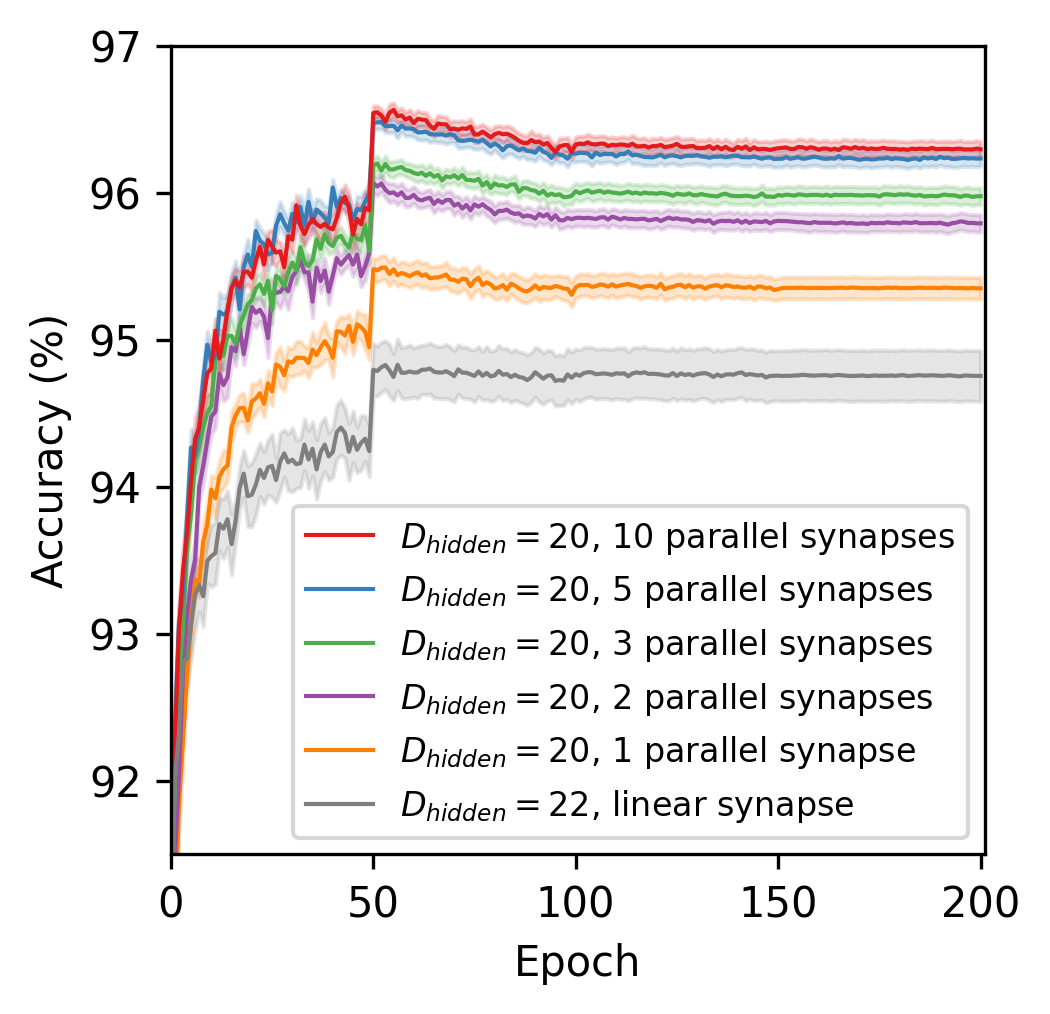

In [14]:

plt.figure(figsize=(3.5, 3.5),dpi=300)
# Get the 'Pastel1' colormap
cmap = plt.cm.get_cmap('Set1')

# Define the number of discrete colors you want
num_colors = 5

# Get the discrete colors from the colormap
colors = [cmap(i) for i in range(num_colors)]
colors = colors[::-1]
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink','tab:gray']
H = 20

for i,M in enumerate([1,2,3,5,10]):
        file_name = f'./results/parallel_nll_H{H}_M{M}_bias10_range50_lr_thres0.05_lr_ampli0.001_lr_slope0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v3.pkl'
        with open(file_name, 'rb') as f:
                results1 = pickle.load(f)[:15]
        if M == 1:
                label = r'$D_{hidden} =20$,'+f' {M} parallel synapse'
        else:
                label = r'$D_{hidden} =20$,'+f' {M} parallel synapses' 
                                                

        print(len(results1))
        acc1 = get_acc(results1) 
        plt.plot(acc1.mean(axis=0), label= label, linestyle='-', linewidth = 1,color=colors[i])
        plt.fill_between(np.arange(acc1.shape[1]), 
                acc1.mean(axis = 0) - acc1.std(axis = 0)/np.sqrt(len(results1)), 
                acc1.mean(axis = 0) + acc1.std(axis = 0)/np.sqrt(len(results1)), alpha = 0.2, color=colors[i])
        
        print(label + ' acc mean +/- std: {:.2f} \pm {:.2f} \%'.format(acc1.mean(axis=0)[100], acc1.std(axis = 0)[100]/np.sqrt(len(results1))) )


for i,H in enumerate([ 22]):
        file_name = f'./results/2nn_nll_H{H}_schedulerTrue_decrease_50_epoch_factor_0.1.pkl'
        with open(file_name, 'rb') as f:
                results1 = pickle.load(f)[:15]
        label = r'$D_{hidden} =22$,'+f' linear synapse' 
        
        print(len(results1))
        acc1 = get_acc(results1)
        # plt.subplot(1,2,1)
        plt.plot(acc1.mean(axis=0), label= label, linestyle='-', linewidth = 1,color='tab:grey')
        plt.fill_between(np.arange(acc1.shape[1]), 
                acc1.mean(axis = 0) - acc1.std(axis = 0)/np.sqrt(len(results1)), 
                acc1.mean(axis = 0) + acc1.std(axis = 0)/np.sqrt(len(results1)), alpha = 0.2, color='tab:grey')
        print(label + ' acc mean +/- std: {:.2f} \pm {:.2f}\% '.format(acc1.mean(axis=0)[100], acc1.std(axis = 0)[100]/np.sqrt(len(results1))) )

H = 20 
handle, labels = plt.gca().get_legend_handles_labels()
order = [4,3,2,1,0,5]
plt.legend([handle[idx] for idx in order],[labels[idx] for idx in order], loc='lower right', fontsize = 8, bbox_to_anchor=(1., 0))
# plt.legend( loc='lower right', fontsize = 8, bbox_to_anchor=(1., 0))


plt.ylim([91.5, 97.])
plt.xlim([0, acc1.shape[1]])
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.savefig('./results_MNIST/parallel_synapse_H_{H}.pdf', bbox_inches='tight')

## parallel synapse, model statistics:

In [144]:
    
from scipy.interpolate import interp1d
def plot_input_histogram_to_parallel_synapse_layer_v2(model, 
                                                testloader, 
                                                hidden_act:str = 'relu', 
                                                is_normalized = False,
                                                file_name = '',
                                                is_scaler = True,
                                                is_sign = False) -> None:
    '''
    plot histograms of hidden layer input and final layer input 
    with histogram normalization
    
    also plot learned aggregate synaptic function for each hidden-output connection
    grouped by output unit
    
    Inputs:
        model: nn.Module
        testloader: torch.utils.data.DataLoader
        hidden_act: str, 'sigmoid' or 'relu', default: 'relu'
        is_normalized: bool, whether to normalize input histogram
        file_name: str, file name to save figure
        is_scaler: bool, whether to multiply aggregate synaptic function with the magnitude of scaler, |c_{i,k}|
        is_sign: bool, whether to multiply aggregate synaptic function with the sign of scaler, sgn(c_{i,k})
    '''
    
    # collection hidden layer input from test dataset
    hidden = []
    final = []
    for inputs, labels in testloader:
        inputs = inputs.view(-1, 28*28)#.to(device)
        if hidden_act == 'sigmoid':
            hidden.append(torch.sigmoid(model.fc1(inputs)).detach().cpu())
        elif hidden_act == 'relu':
            hidden.append(torch.relu(model.fc1(inputs + model.additive_bias)).detach().cpu())
        final.append(model.parallel_synapse(hidden[-1]).detach().cpu())
        
    hidden_thres = 1e-4 # if hidden unit input is too small and close to zero, we ignore it
    hidden = torch.cat(hidden, dim=0)
    hidden = hidden.data.cpu().numpy() # n_data x n_hidden
    final = torch.cat(final, dim=0)
    f = model.parallel_synapse
    slope = f.slope
    ampli = f.ampli
    thres = f.thres
    input_dim = slope.shape[1]
    n_data = 100
    output_dim = slope.shape[-1]
    
    hidden_list = [] 
    input_list = []
    for i in np.arange(hidden.shape[1]):
        tmp_hidden = hidden[:, i].ravel()
        
        tmp_hidden = np.sort(tmp_hidden[tmp_hidden > hidden_thres])
        
        min_val =0# min(tmp_hidden.min(), model.parallel_synapse.thres[:, i,:].detach().numpy().min()-1)
        max_val = max(tmp_hidden.max(), model.parallel_synapse.thres[:, i,:].detach().numpy().max()+1)
        freq, x = np.histogram(tmp_hidden, bins= np.linspace(min_val, max_val, n_data))
        cdf = np.cumsum(freq) / np.sum(freq) 
        # concatenate 0 and cdf values
        cdf = np.concatenate([[0], cdf])
        y = cdf
        fu = interp1d(y, x)
        xnew = np.linspace(0, 1, 101)
        ynew = fu(xnew)
        input_list.append(ynew)
        hidden_list.append(tmp_hidden[tmp_hidden > hidden_thres])
    
    input = torch.cat([torch.tensor(input_list[i]).reshape(-1, 1) for i in np.arange(hidden.shape[1])], dim = 1)
    

    
    
    # for each hidden unit, we get its input range, and create input value with n_data bins
    
    # # input = torch.cat([torch.linspace(0, hidden_list[i].std()*4 + hidden_list[i].mean(), steps = n_data).reshape(-1, 1) for i in np.arange(hidden.shape[1])], dim = 1)

    # all_freq = []
    # # also for get hidden unit input histogram, so that we can stretch the aggregate synaptic function 
    # # such that the x-axis is input percentile
    # for i in np.arange(hidden.shape[1]):
    #     tmp_hidden = hidden[:, i].ravel()
    #     tmp_hidden = tmp_hidden[tmp_hidden > hidden_thres]
    #     freq, _ = np.histogram(tmp_hidden, bins=input[:,i].numpy())
            
    #     all_freq.append((freq/np.sum(freq)).cumsum())
    # freq = np.vstack(all_freq)
    
    n_data = input.shape[0]
    n_synapse = slope.shape[0]
    
    # aggregate synaptic function
    x = slope[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim) \
        * (input[:, None, :, None].expand(n_data, n_synapse, input_dim, output_dim)
        - thres[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim))
    x = torch.tanh(x)
    x = x * (ampli[None, :, :, :]**2 ).expand(n_data, n_synapse, input_dim, output_dim)
    if is_scaler and is_sign:
        x = x.detach().numpy() * f.scaler[None, None, :, :].expand(n_data, n_synapse, input_dim, output_dim).detach().numpy()
    elif is_scaler and not is_sign:
        x = x.detach().numpy() * np.abs(f.scaler[None, None, :, :].expand(n_data, n_synapse, input_dim, output_dim).detach().numpy())
    elif not is_scaler and not is_sign:
        x = x.detach().numpy()
    x = x.sum(axis=1).squeeze() # shape: n_data x input_dim x output_dim
    
    
    if is_sign and is_scaler:
        plt.figure(figsize = (8, 7), dpi=300)
        for i in range(20):
            # hidden unit activation histogram
            plt.subplot(4,5,i+1)
            plt.hist(hidden_list[i], bins=input[:,i], density=True)
            plt.title( 'Hidden unit ' +str(i+1))
            plt.xlabel('Activation')
        plt.tight_layout()
        plt.savefig(file_name + '_hidden_activation.pdf')
    plt.show()
    
    # aggregate synaptic function
    plt.figure(figsize = (7.5, 6), dpi=300)
    plt.rcParams.update({'font.size': 8})
    print('transmission function, scaler = ' + str(is_scaler) + ', sign = ' + str(is_sign))
    for i in np.arange(min([20, output_dim])):
        plt.subplot(4,5,i+1)
        plt.plot(x[:-1,:,i], linewidth = 1.,alpha = 0.8)# shape: n_data x input_dim x output_dim
        plt.title(   'Output unit ' + str(i+1), fontsize=8)
        plt.xlabel('Input (percentile)', fontsize=8)
    plt.tight_layout()
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()
    return x

loading  ./results/parallel_nll_H20_M3_bias10_range50_lr_thres0.05_lr_ampli0.001_lr_slope0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v3.pkl


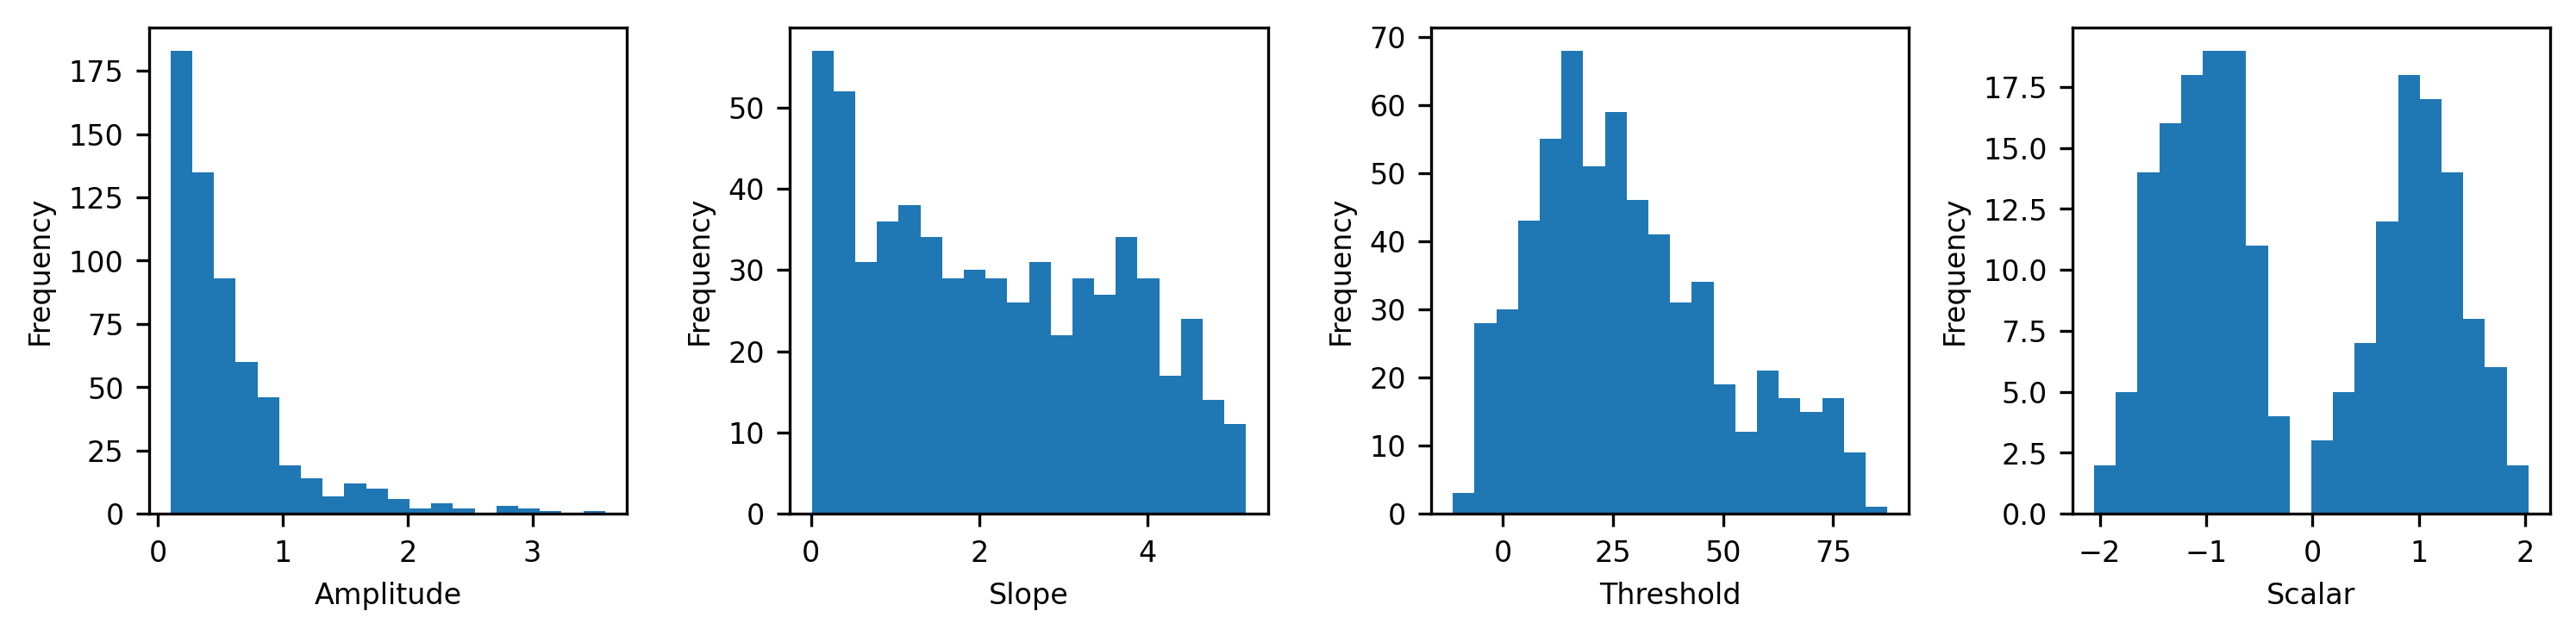

ValueError: zero-size array to reduction operation maximum which has no identity

In [145]:
H=20
for M in [3]:

    for bias in [10]:
        loss_type = 'nll'
        file_name = './results/parallel_'+loss_type+f'_H{H}_M{M}_bias10_range50_lr_thres0.05_lr_ampli0.001_lr_slope0.001_schedulerTrue_decrease_50_epoch_factor_0.1_initialization_v3.pkl'
        print('loading ', file_name)
        with open(file_name, 'rb') as f:
            results = pickle.load(f)

        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

        testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
        for i,result in enumerate(results[2:3]):
            model = result['model']
            
            plot_parallel_synapse_params(model)

            
            actv = plot_input_histogram_to_parallel_synapse_layer_v2(model, testloader, hidden_act='relu', 
                        file_name = f'./results/parallel_synapse_H_{H}_M_{M}_trial_{i+1}_signed_scaled.pdf', is_sign=True) 
            actv = plot_input_histogram_to_parallel_synapse_layer_v2(model, testloader, hidden_act='relu',
                        file_name = f'./results/parallel_synapse_H_{H}_M_{M}_trial_{i+1}_unsigned_scaled.pdf', is_sign=False)
            actv = plot_input_histogram_to_parallel_synapse_layer_v2(model, testloader, hidden_act='relu',
                        file_name = f'./results/parallel_synapse_H_{H}_M_{M}_trial_{i+1}_unsigned_unscaled.pdf', is_sign=False, is_scaler=False)


In [146]:
model.additive_bias

10

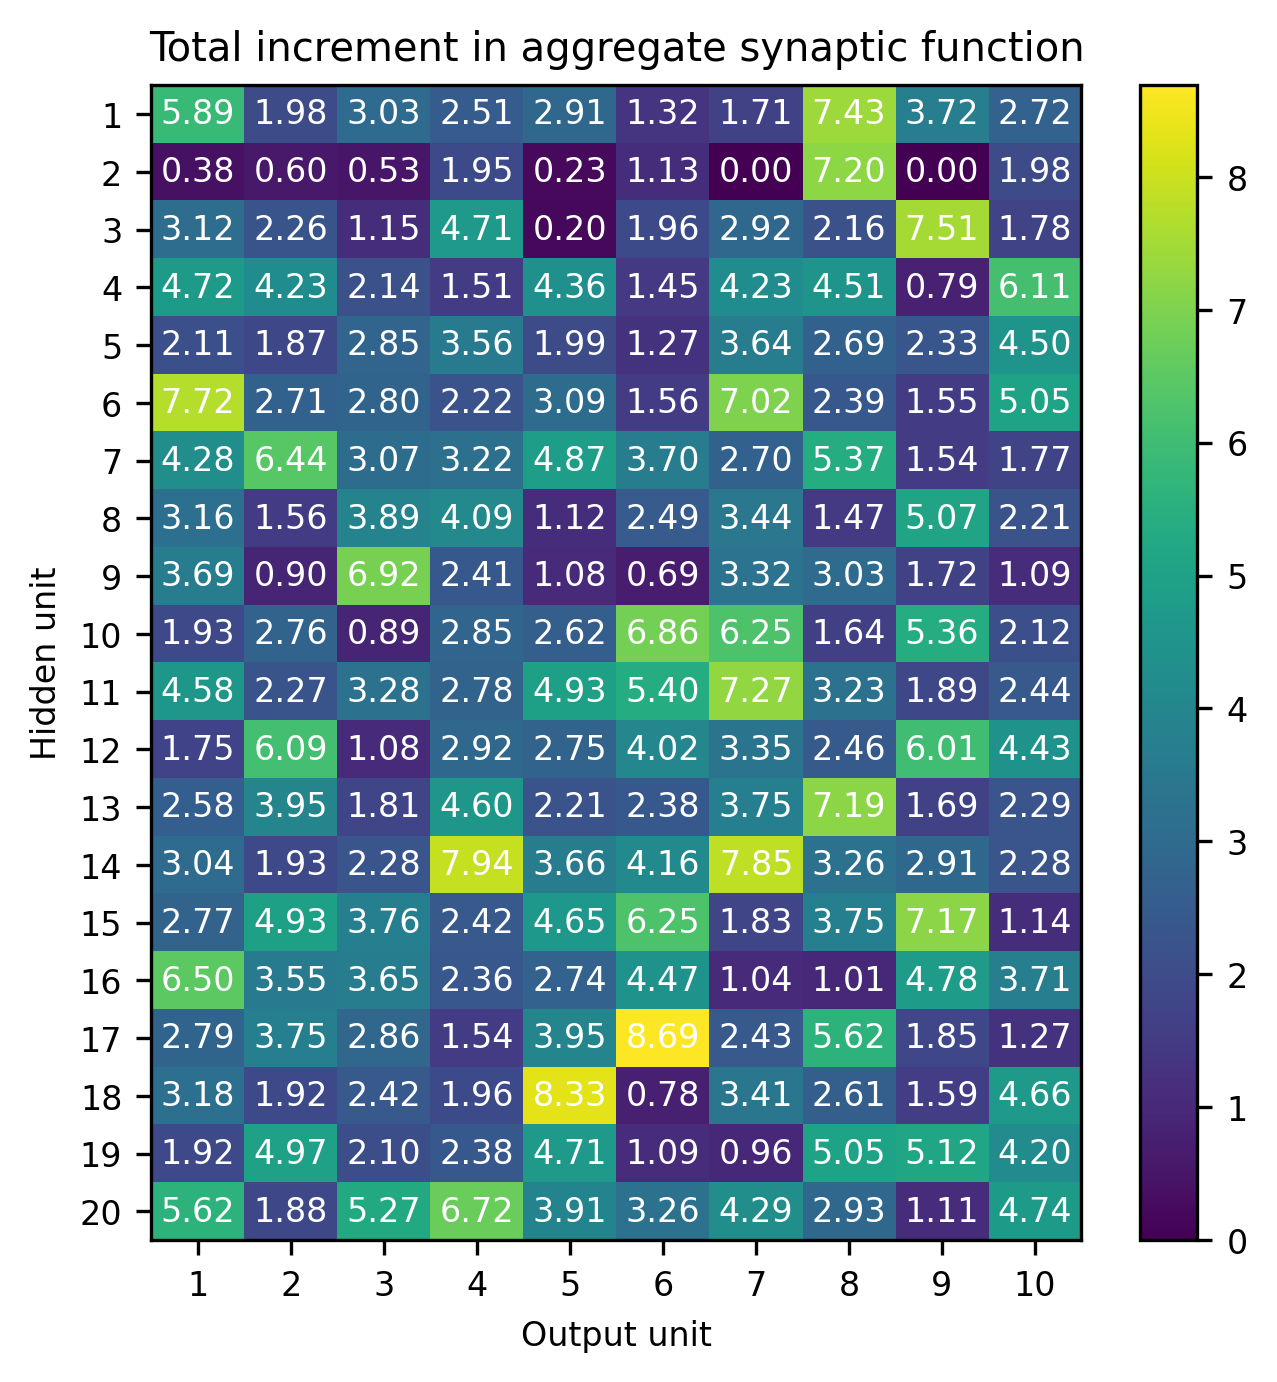

In [140]:
plt.figure(figsize=(5, 5), dpi=300)
plt.imshow(diff_actv, aspect='auto')
# add text to each cell
for i in range(diff_actv.shape[0]):
    for j in range(diff_actv.shape[1]):
        plt.text(j, i, '{:.2f}'.format(diff_actv[i, j]),
                ha="center", va="center", color="w")
plt.xticks(np.arange(0, 10, 1), labels=np.arange(1, 11, 1))
plt.yticks(np.arange(0, 20, 1), labels=np.arange(1, 21, 1))
plt.xlabel('Output unit')
plt.ylabel('Hidden unit')
plt.title('Total increment in aggregate synaptic function')
plt.colorbar()

In [143]:
print('slope : ')
print(model.parallel_synapse.slope[:,1,8].detach().numpy())
print('ampli : ')
print(model.parallel_synapse.ampli[:,1,8].detach().numpy())
print('thres : ')
print(model.parallel_synapse.thres[:,1,8].detach().numpy())

slope : 
[1.4710088 3.666423  2.6465557]
ampli : 
[0.7367259  0.5345861  0.35954842]
thres : 
[15.482093  14.575405   3.0436168]


In [ ]:
hidden_

In [ ]:
'''
plot 2nn model training results and hidden activation
'''
# results = pickle.load(open('./results_MNIST/2nn_nll_H22_schedulerTrue_decrease_50_epoch_factor_0.1.pkl', 'rb'))
# for result in results[:1]:
#     model = result['model']
#     hidden, final = get_hidden_final_activation_2NN(model, testloader)
#     plot_hidden_final_loss_2NN(model, hidden, final, result)
#     plt.show()

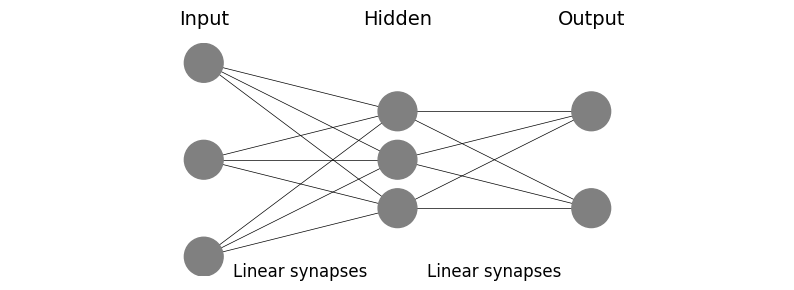

In [62]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Define a function to create a circle
def create_circle(x, y, radius=0.1, color='blue'):
    return plt.Circle((x, y), radius, color=color, fill=True, zorder=10)

# Define the positions of the nodes in each layer
input_positions = [(1, 1), (1, 0.5), (1, 0)]
hidden_positions = [(2, 0.75), (2, 0.5), (2, 0.25)]
output_positions = [(3, 0.75), (3, 0.25)]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Create circles for the input layer
for position in input_positions:
    circle = create_circle(position[0], position[1], color='grey')
    ax.add_artist(circle)

# Create circles for the hidden layer
for position in hidden_positions:
    circle = create_circle(position[0], position[1], color='grey')
    ax.add_artist(circle)

# Create circles for the output layer
for position in output_positions:
    circle = create_circle(position[0], position[1], color='grey')
    ax.add_artist(circle)

# Connect each node in the input layer with every node in the hidden layer
for input_position in input_positions:
    for hidden_position in hidden_positions:
        ax.plot([input_position[0], hidden_position[0]], [input_position[1], hidden_position[1]], 'k-', lw=0.5)

# Connect each node in the hidden layer with every node in the output layer
for hidden_position in hidden_positions:
    for output_position in output_positions:
        ax.plot([hidden_position[0], output_position[0]], [hidden_position[1], output_position[1]], 'k-', lw=0.5)

# Set limits, aspect and remove the axes
ax.set_xlim(0, 4)
ax.set_ylim(-0.1, 1.1)
ax.set_aspect('equal')
ax.axis('off')

# Add layer names
plt.text(1, 1.2, 'Input' , fontsize=14, ha='center')
# plt.text(1, 1.2, , fontsize=14, ha='center')
plt.text(2, 1.2, 'Hidden', fontsize=14, ha='center')
plt.text(3, 1.2, 'Output', fontsize=14, ha='center')

# add rectangles to the input layer

# rect = patches.Rectangle((2.2, 0.2), .6, 0.6, edgecolor='red', facecolor='none', zorder=10)
# ax.add_patch(rect)

plt.text(1.5, -.1, 'Linear synapses', fontsize=12, ha='center')
plt.text(2.5, -.1, 'Linear synapses', fontsize=12, ha='center')
# plt.text(2.5, -.1, 'Parallel synapses', fontsize=12, ha='center', color='red')
plt.text(1.5, 1.5, '', fontsize=12, ha='center')
# plt.title('2NN model with parallel synapses', fontsize=14)
# Show the plot
plt.savefig('./results_MNIST/2nn_parallel.pdf', bbox_inches='tight')
plt.show()
